# Meyer-Entel Generator

This Notebook generates LAMMPS style potential files for the 1998 Meyer-Entel Fe and Ni potentials

In [23]:
from copy import deepcopy

import numpy as np

import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline
from scipy.special import factorial

from potentials.paramfile import EAM, eam_to_eam_alloy

## 1. Define function forms

This section defines the functional forms used by the potential.  Each of the three function categories takes the form 

    function(input, **kwargs)
    
where input is either rho or r, and kwargs are any function parameters not explicitly set by the function definition.  Functions for different interactions can be defined either

- as completely separate functions, or
- by defining a functional form and specifying the interaction-dependent parameters using kwargs.

### $F(\bar{\rho})$ function(s)

The embedding energy functions are cubic spline functions with specified nodes and derivatives



In [2]:
def F(ρ, **kwargs):
    
    # Extract the nodes
    ρ_nodes = kwargs['F(ρ)_ρ_nodes']
    F_nodes = kwargs['F(ρ)_F_nodes']
    
    # Fit a spline with second derivative=0 end points
    Fspline = CubicSpline(ρ_nodes, F_nodes, bc_type='natural')
    
    # Apply cutoff
    ρmax = ρ_nodes[-1]
    return np.piecewise(ρ, [ρ < ρmax, ρ >= ρmax], [Fspline, 0])

### $\rho(r)$ function(s)

The embedding density function is

$$ \rho(r) = N_{s} \rho_s(r) + (N - N_s)\rho_d(r) - \rho_c$$,

where

- $N$ is the total valence electrons
- $N_s$ is an empirical parameter to capture the s-like content of the atomic density
- $\rho_s$ is the electonic density from the 4s orbital
- $\rho_d$ is the electronic density from the 3d orbital
- $\rho_c$ is a constant that is applied such that $\rho(r_c)=0$ 

The $\rho_s$ and $\rho_d$ expressions are computed using the double-zeta Roothaan-Hartree-Fock functions of Clementi and Roetti. The equations for $\rho_s$ and $\rho_d$ are taken from Daw and Baskes 1984 and the parameters are taken from Clementi and Roetti.

$$ \rho_s(r) = \left| \sum_i C_i R_i(r) \right|^2 / 4 \pi $$

$$ R_i(r) = \frac{(2\zeta_i)^{(n_i+1/2)}}{[(2n_i)!]^{1/2}} r^{n_i-1} e^{-\zeta_i r} $$

In [3]:
def ρ_s(r, **kwargs):
    """
    Computes the density for the s orbital
    """
    cz = np.zeros_like(r)
    for c, ζ, n in zip(kwargs['c_s'], kwargs['ζ_s'], kwargs['n_s']):
        d = (2 * ζ)**(n + 0.5) / (factorial(2 * n))**0.5
        rr = r**(n-1) * np.exp(-ζ*r)
        cz += c * d * rr
    
    return cz**2 / (4 * np.pi)
    
def ρ_d(r, **kwargs):
    """
    Computes the density for the d orbital
    """
    cz = np.zeros_like(r)
    for c, ζ, n in zip(kwargs['c_d'], kwargs['ζ_d'], kwargs['n_d']):
        d = (2 * ζ)**(n + 0.5) / (factorial(2 * n))**0.5
        rr = r**(n-1) * np.exp(-ζ*r)
        cz += c * d * rr
    
    return cz**2 / (4 * np.pi)    
    
def ρ_raw(r, **kwargs):
    """
    Computes the total density as a scaled sum of rho_s and rho_d
    """
    N = kwargs['N']
    Ns = kwargs['Ns']
    
    return Ns * ρ_s(r, **kwargs) + (N - Ns) * ρ_d(r, **kwargs)

def ρ_norm(r, **kwargs):
    # Convert r from Angstroms to aBohr
    #r = r / aBohr
    
    # Extract scaling factor
    ρ0 = kwargs['ρ0']
    
    # Calculate rho_c
    rc = kwargs['rc']
    ρc = ρ_raw(rc, **kwargs)
    
    return (ρ_raw(r, **kwargs) - ρc) / ρ0
    
def rho(r, **kwargs):
    """
    Computes rho using the given parameters
    """
    
    rc = kwargs['rc']
    
    # Construct the normalized function
    return np.piecewise(r, [r <= rc, r > rc], [ρ_norm, 0.0], **kwargs)
    

Full tables from Clementi and Roetti for the double zeta functions

#### Fe 

|basis/orb|zeta (1/aBohr)|1S|2S|3S|4S|2P|3P|3D|
|--|--|--|--|--|--|--|--|--|
|1S| 27.03350 |0.79062 |-0.03115 |0.01291 |-0.00392|
|1S| 19.01040| 0.22775| -0.42273| 0.15437| -0.03027|
|2S| 13.51700| -0.02991| 0.09856| 0.08859| -0.02829|
|2S| 10.13050| 0.01485| 1.05733| -0.64916| 0.15090|
|3S| 5.21660 |-0.00246| 0.01978| 0.79159| -0.21377|
|3S| 3.47616 |0.00141 |-0.00608| 0.37233| -0.05096|
|4S| 1.92517 |-0.00036| 0.00132| -0.00372| 0.50156|
|4S| 1.07742| 0.00014 |-0.00049| 0.00117| 0.60709|
|2P|16.90320||||| 0.15201| -0.04331| 
|2P| 9.98637 |||||0.86001| -0.35185 |
|3P| 5.13914 |||||0.02116| 0.66557|
|3P| 3.15454 |||||-0.00492| 0.45730|
|3D| 6.06828||||||| 0.40379|
|3D| 2.61836||||||| 0.71984|

#### Ni

|basis/orb|zeta (1/aBohr)|1S|2S|3S|4S|2P|3P|3D|
|--|--|--|--|--|--|--|--|--|
|1S| 29.03620| 0.80410 |-0.03033 |0.01217 |-0.00389|
|1S| 20.35820| 0.21401| -0.43324 |0.16094 |-0.02991|
|2S| 14.50890| -0.03086| 0.10437| 0.10101 |-0.03189|
|2S| 11.04660| 0.01581 |1.05849 |-0.67582 |0.15289|
|3S| 5.79629| -0.00244 |0.02028 |0.76084 |-0.20048|
|3S| 3.87206| 0.00133 |-0.00576 |0.40933 |-0.05423|
|4S| 2.07712| -0.00031| 0.00115 |-0.00148| 0.49292|
|4S| 1.13888| 0.00012| -0.00043 |0.00057 |0.61875|
|2P| 18.27370 |||||0.14815 |-0.04176 |
|2P| 10.94080||||| 0.86219 |-0.36079 |
|3P| 5.67113||||| 0.02149 |0.67532|
|3P| 3.45098||||| -0.00468 |0.45202|
|3D| 6.70551 |||||||0.42120|
|3D| 2.87381 |||||||0.70658|

### z(r) function(s)

The effective charge functions are cubic spline functions with specific limits.

In [4]:
def z(r, **kwargs):
    
    # Extract the nodes
    alat = kwargs['alat']
    r_nodes = alat * kwargs['z(r)_r_nodes']
    z_nodes = kwargs['z(r)_z_nodes']
    
    # Fit a spline with first derivative=0 end points
    zspline = CubicSpline(r_nodes, z_nodes, bc_type='clamped')
    
    # Apply cutoff
    rmax = r_nodes[-1]
    return np.piecewise(r, [r < rmax, r >= rmax], [zspline, 0])

## 2. Specify parameters

In [5]:
# Specify the unit scaling factors to use
convert = 'lammps'

if convert == 'lammps':
    # LAMMPS values (short)
    aBohr = 0.529
    Hartree = 27.2
elif convert == 'precise':
    # Actual values (full)
    aBohr = 0.529177210903
    Hartree = 27.21138624598741
else:
    raise ValueError('convert can only be "lammps" or "precise')

Ry = Hartree / 2

# Initialize the parameter dictionary
params = {}

### 2.1 Fe parameters

In [12]:
params['Fe'] = {}

# Atomic data
params['Fe']['number'] = 26
params['Fe']['mass'] = 55.847
params['Fe']['alat'] = 2.867
params['Fe']['lattice'] = 'bcc'

# F(ρ) spline nodes
params['Fe']['F(ρ)_ρ_nodes'] = np.array([0.0, 0.5, 1.0, 2.0, 2.3])
params['Fe']['F(ρ)_F_nodes'] = np.array([0.0, -0.2823, -0.4276, -0.3030, 0.0]) * Ry

# Z(r) spline nodes
params['Fe']['alat'] = 5.42 * aBohr
params['Fe']['z(r)_r_nodes'] = np.array([0.0, 0.7, 0.87, 0.94, 1.0, 1.2])
params['Fe']['z(r)_z_nodes'] = np.array([26.0, 1.4403, 0.2452, 0.1491, 0.0734, 0.0])

# ρ(r) parameters
params['Fe']['N'] = 8
params['Fe']['Ns'] = 0.57
params['Fe']['rc'] = 8.332 * aBohr
params['Fe']['ρ0'] = 2.776e-3 * aBohr**-3

# 4s orbital function parameters
params['Fe']['n_s'] = np.array([1,1,
                                2,2,
                                3,3,
                                4,4])
params['Fe']['c_s'] = np.array([-0.00392, -0.03027,
                                -0.02829,  0.15090,
                                -0.21377, -0.05096,
                                 0.50156,  0.60709])
params['Fe']['ζ_s'] = np.array([27.03350, 19.01040, 
                                13.51700, 10.13050,
                                 5.21660,  3.47616,
                                 1.92517,  1.07742]) / aBohr 

# 3d orbital function parameters
params['Fe']['n_d'] = np.array([3,3])
params['Fe']['c_d'] = np.array([0.40379, 0.71984])
params['Fe']['ζ_d'] = np.array([6.06828, 2.61836]) / aBohr 

### 2.2 Ni parameters

In [13]:
params['Ni'] = {}

# Atomic data
params['Ni']['number'] = 28
params['Ni']['mass'] = 58.6934
params['Ni']['alat'] = 3.519
params['Ni']['lattice'] = 'fcc'

# F(ρ) spline nodes
params['Ni']['F(ρ)_ρ_nodes'] = np.array([0.0, 0.5, 1.0, 2.0, 2.3])
params['Ni']['F(ρ)_F_nodes'] = np.array([0.0, -0.2695, -0.3961, -0.2654, 0.0]) * Ry

# Z(r) spline nodes
params['Ni']['alat'] = 6.65 * aBohr
params['Ni']['z(r)_r_nodes'] = np.array([0.0, 0.60, 0.71, 0.85])
params['Ni']['z(r)_z_nodes'] = np.array([28.0, 0.9874, 0.1596, 0.0])

# ρ(r) parameters
params['Ni']['N'] = 10
params['Ni']['Ns'] = 0.85
params['Ni']['rc'] = 8.777 * aBohr
params['Ni']['ρ0'] = 4.187e-3 * aBohr**-3

# 4s orbital function parameters
params['Ni']['n_s'] = np.array([1,1,
                                2,2,
                                3,3,
                                4,4])
params['Ni']['c_s'] = np.array([-0.00389, -0.02991,
                                -0.03189,  0.15289,
                                -0.20048, -0.05423,
                                 0.49292,  0.61875])
params['Ni']['ζ_s'] = np.array([29.03620, 20.35820,
                                14.50890, 11.04660,
                                 5.79629,   3.87206,
                                 2.07712,   1.13888]) / aBohr  

# 3d orbital function parameters
params['Ni']['n_d'] = np.array([3,3])
params['Ni']['c_d'] = np.array([0.42120, 0.70658])
params['Ni']['ζ_d'] = np.array([6.70551, 2.87381]) / aBohr

## 3. Build potential parameters

Parameters to specify

In [16]:
symbol = 'Fe'
numr = numρ = 20001

# Write a header
header = f'Meyer-Entel potential test potential for {symbol}'

Initialize parameter file builder

In [17]:
p = params[symbol]

builder = EAM(header=header, numr=numr, numrho=numρ,
              cutoffr=p['rc'], cutoffrho=p['F(ρ)_ρ_nodes'][-1],
              number=p['number'], mass=p['mass'], alat=p['alat'], lattice=p['lattice'])

Set functions using symbol-specific parameters

In [18]:
builder.set_F_rho(fxn=F, **p)
builder.set_rho_r(fxn=rho, **p)
builder.set_z_r(fxn=z, **p)

Text(0, 0.5, 'F(ρ)')

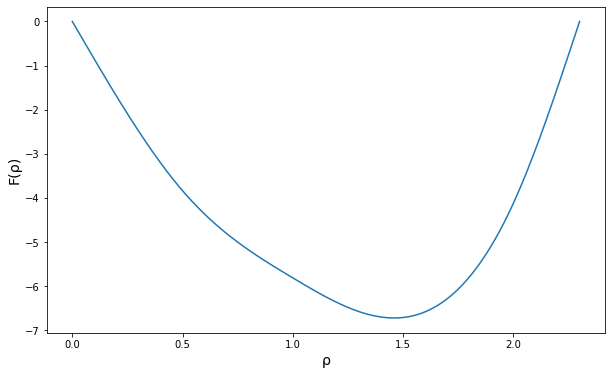

In [19]:
fig = plt.figure(figsize=(10, 6))
plt.plot(builder.rho, builder.F_rho())
plt.xlabel('ρ', size='x-large')
plt.ylabel('F(ρ)', size='x-large')

Text(0, 0.5, 'ρ(r)')

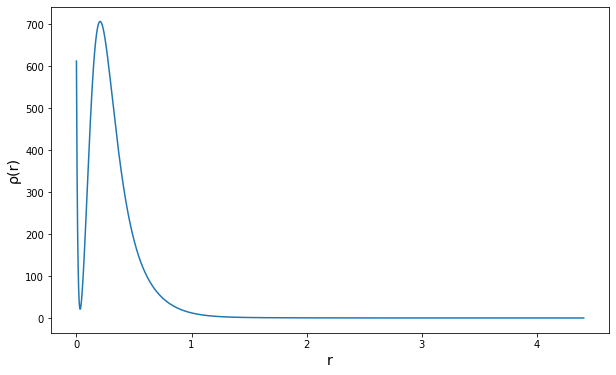

In [20]:
fig = plt.figure(figsize=(10, 6))
plt.plot(builder.r, builder.rho_r())
plt.xlabel('r', size='x-large')
plt.ylabel('ρ(r)', size='x-large')

Text(0, 0.5, 'z(r)')

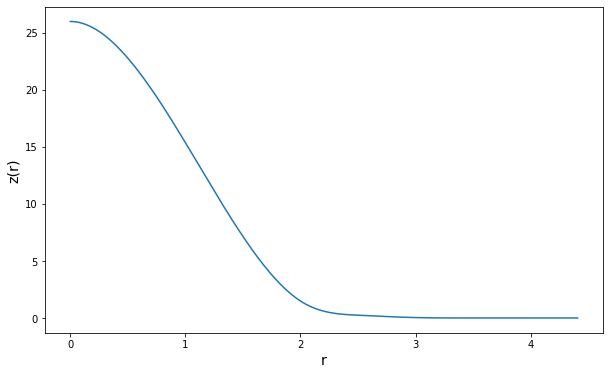

In [21]:
fig = plt.figure(figsize=(10, 6))
plt.plot(builder.r, builder.z_r())
plt.xlabel('r', size='x-large')
plt.ylabel('z(r)', size='x-large')

## 4. Build parameter file

### 4.1 Create eam style file

In [ ]:
print(builder.build(ncolumns=4))

### 4.2 Create eam/alloy style file

In [ ]:
builder2 = eam_to_eam_alloy(builder, symbol)
print(builder2.build(ncolumns=4))